$$\require{cancel}$$
$$\require{enclose}$$
$$\newcommand{\can}[1]{\|#1\|^{\text{can}}}$$


$$\gdef\can #1{\|#1\|^{\text{can}}}$$


Acompannying [blog post](https://bit-ml.github.io/blog/post/bgv-python/) with more details.

## Prerequisites

- FHE (Fully Homomorphic Encryption) pdf
- Lattices, RLWE (Ring Learning with errors)


# Theory

- [BGV paper](https://eprint.iacr.org/2011/277.pdf) - Original
- [FHE standard](https://homomorphicencryption.org/standard/)
- [Inferati blogpost](https://www.inferati.com/blog/fhe-schemes-bgv)
- [BV paper](https://eprint.iacr.org/2011/344.pdf)
- [FHE schemes comparisons](https://eprint.iacr.org/2015/889.pdf)


**What to expect from this notebook?**

1. We present the BGV scheme.
2. We offer a Python implementation for the BGV scheme, for educational purposes.


Firstly, this scheme allows us to encrypt messages into ciphertexts. Intuitively, a message is hidden in a ciphertext if there is no way to get to retrieve the original message from its encryption. To an attacker that sees a ciphertext, that ciphertext should look like "random garbage". In order to achieve this we hide the message by "masking" it with some noise. We say it's _hard_ for an attacker to retrieve a message from its ciphertext if doing so is at least as hard as solving a computationally unfeasable problem. The problem the security of the BGV scheme is based on is called the [**Ring Learning with Errors problem**](https://en.wikipedia.org/wiki/Ring_learning_with_errors).

Secondly, the scheme allows us to perform arithmetic operations (additions, multiplications) using noisy ciphertexts. However, we will encounter some problems along the way, such as the noise increasing after computations, or the size of the resulting ciphertext increasing. We'll see how to handle these using **modulus switching** (for the former) and **relinearization** (for the latter).

This post will get a bit mathematical, so before starting we introduce some notation. Any other notation will be defined when introduced.


Notations:

- $m, m', m^*$ - messages.
- $c, c', c^*$ - ciphertexts. If ciphertexts have more components, we denote the components with indices: $c = (c_0, c_1)$
- $\lambda$ - Security parameter.
- $\mathbb Z_q$ - the set of integers from $(-q / 2, q / 2]$
- $R$ - Ring.
  - Ex: $\mathbb Z$ - the integers.
  - Ex: $\mathbb Z[X] / (X^n + 1)$ - the quotient polynomial ring with integer coefficients: .
- $R_q$ - Ring modulo the ideal generated by $q$.
  - Ex: $\mathbb Z_q$ - the integers mod $q$.
  - Ex: $\mathbb Z_q[X]/ (X^n + 1)$ - the quotient polynomial ring with coefficients being integers in $(-q / 2, q / 2]$.
- $[a]_q$ - $a \bmod q$, coefficients centered in $(-q / 2, q / 2]$. When applying $[\cdot ]_q$ to a polynomial we mean to apply it to all its coefficients individually. When applying $[\cdot]$ to a vector of elements, we mean to apply it to each element individually. So $[(a, b)]_q = ([a]_q, [b]_q)$. We give the similar treatment to reduction $\bmod q$ operation
- $\chi = \chi(\lambda)$ - Noise distribution, parametrized by $\lambda$ (usually Gaussian).
- For simplicity, when we say we sample a polynomial from some distribution (or a polynomial comes from some distribution) we mean that its coefficients are sampled independently from that distribution.
- $e \leftarrow \chi$ - An element $e$ sampled from the distribution $\chi$
- $a \xleftarrow R S$ - An element sampled uniformly from a set $S$
  - Ex: $a \xleftarrow R R_q$ An element $a$ sampled uniformly from the ring $R_q$
- $a \cdot b$ denotes the multiplication of 2 elements from the ring $R_q$.
- $ta$ denotes the multiplication of coefficients of $a \in R_q$ by some scalar $t$.


We will now describe the RLWE problem.

Consider the quotient polynomial ring $R_q = \mathbb Z_q[X]/ (X^n + 1)$. This ring has polynomials with degree at most $n$ and integer coefficients in $(-q / 2, q / 2]$.

**The RLWE problem - decision**
: The problem asks to distinguish between the following two distributions: - $(a_i, b_i)$ with $a_i \xleftarrow R R_q$, $b_i \xleftarrow R R_q$. - $(a_i, b_i)$ with $a_i \xleftarrow R R_q$, $e_i \leftarrow \chi$, and $b_i = a_i \cdot s + e_i$ for some "small" secret $s \in R_q$ sampled before.

The RLWE problem also has a search version, where given pairs $(a_i, b_i)$, $b_i = a_i \cdot s + e_i$ you need to find $s$. In practice, the decision version is more widely used when proving the security of different schemes.

More details about the RLWE problem can be found in this [paper](https://eprint.iacr.org/2012/230.pdf). In essence, by adding some small noise $e_i$, from a Gaussian distribution, we make our secret $s$ unrecoverable even if we have access to many RLWE samples.


## Encryption scheme


Generate the following parameters

- $n$ - degree of $X^n + 1$. $n$ is chosen as a power of 2.
- $q$ - ciphertext modulus.
- $t$ - plainext modulus, $t \ll q$.
- $\chi$ - the noise distribution, a discrete Gaussian.

We consider $R_q = \mathbb Z_q[X] / (X^n + 1)$. This ring has polynomials with degree at most $n$ and integer coefficients in $(-q / 2, q / 2]$.

**Note**:

- All polynomial operations are considered $\bmod q$ unless otherwise specified, to ease notation.
- When we talk about "small" polynomials, we intuitively think about them having small coefficients.

We will have one secret key $sk$, a public key with two components $pk = (pk_0, pk_1)$, a ciphertext with 2 components $c = (c_0, c_1)$
The messsage will come from the ring $R_t$.

`SecretKeyGen(params) -> sk`

- Draw $s$ from a secret key distribution which outputs "small" elements with overwhelming probability. In practice $s \in \{-1, 0, 1\}^n$, with the probability of sampling $0$ specified as a parameter and the probabilities of sampling $-1$ or $1$ being equal.
- Return the secret key $sk = s$.

`PubKeyGen(sk, params) -> (pk0, pk1)`

- Draw a random element $a \xleftarrow R R_q$ and the noise $e \leftarrow \chi$.
- Return the public key : $pk = (pk_0, pk_1) = \underbrace{(a \cdot s + te, -a)}_{\text{RLWE instance-like}}$.

Notice that the public key looks like a RLWE sample, but the error $e$ is multiplied by the plaintext modulus $t$.

`Encrypt(m, pk, params) -> (c0, c1)`

- Draw the noise $e_0, e_1 \leftarrow \chi$ and a "small" random polynomial $u \xleftarrow R \{-1, 0, 1\}^n$
- Compute $c_0 = pk_0 \cdot u + te_0 + m$
- Compute $c_1 = pk_1 \cdot u + te_1$
- Return $c = (c_0, c_1)$.


**Corectness**

Let's unroll the equations to check the corectness.

The public key is:

$$
\begin{align*}
pk_0 &= a \cdot s + te \\
pk_1 &= -a
\end{align*}
$$

The public key $pk_0$ hides the secret $s$ as a RLWE sample. $pk_1$ will be used in decryption to remove the secret key.

The encryption equations unrolled:

$$
\begin{align*}
c_0 &= pk_0 \cdot u + te_0 + m \\
&= (a \cdot s + te) \cdot u + te_0 + m \\
& = a \cdot s \cdot u + t(e \cdot u) + te_0 + m
\\
c_1 &= pk_1 \cdot u + te_1 \\
&= -a \cdot u + te_1 \\
\end{align*}
$$

The decryption equation unrolled:

$$
\begin{align*}
c_0 + c_1 \cdot s &= a \cdot s \cdot u + t(e \cdot u) + te_0 + m + (-a \cdot u + te_1) \cdot s \\
&= \cancel{a \cdot s \cdot u} + t(e \cdot u) + te_0 + m \cancel{-a \cdot u \cdot s} + t(e_1 \cdot s)\\
&= t(e_1 \cdot s) + t(e \cdot u) + te_0 + m \\
&= t(e \cdot u + e_0 + e_1 \cdot s) + m
\end{align*}
$$

The decryption is correct as long as the error we add to $m$ does not wrap $m$ arond the modulus $q$. The noise analysis will be offered later, in its own section.

Now, we reduce the above $\bmod t$ and we get:
$$c_0 + c_1 \cdot s \equiv m \bmod t$$


## FHE operations


Here we will explore the homomorphic properties of the scheme. We refer to the two input message and ciphertext pairs with $(m, c), (m', c')$ and to the resulting message-ciphertext pair with $(m^*, c^*)$.

The goal is to find two functions, $\text{add}, \text{mul}$, that work on ciphertexts, for addition and multiplication, such that:

- when $m^* = m + m'$ we have $c^* = \text{add}(c, c')$ and $\text{Dec}(c^*) = m^*$
- when $m^* = m \cdot m'$ we have $c^* = \text{mul}(c, c')$ and $\text{Dec}(c^*) = m^*$

Recall that $c$ and $c'$ encrypt $m$ and $m'$ i.e.:

$$
\begin{align*}
c_0 &= pk_0 \cdot u + te_0 + m \\
c_1 &= pk_1 \cdot u + te_1 \\
\\
c'_0 &= pk_0 \cdot u' + te'_0 + m \\
c'_1 &= pk_1 \cdot u' + te'_1 \\
\end{align*}
$$


## FHE Addition

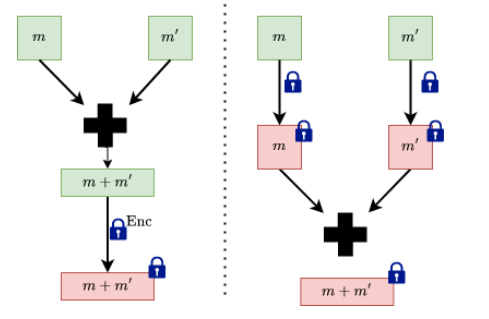

Here we will explore the homomorphic properties of the scheme. We will refer to the two input message and ciphertext pairs with $(m, c), (m', c')$ and to the resulting message ciphertext pair with $(m^*, c^*)$.

The idea is to find an addition and aa multiplication function such that:

- when $m^* = m + m'$ we have $c^* = \text{add}(c, c')$ and decrypting $c^*$ yields $m^*$
- when $m^* = m \cdot m'$ we have $c^* = \text{mul}(c, c')$ and decrypting $c^*$ yields $m^*$


We define `EvalAdd`:
`EvalAdd(c, c') -> c*`

- $c^*_0 = c_0 + c'_0$
- $c^*_1 = c_1 + c'_1$
- return $c^* = (c^*_0, c^*_1)$

**Correctness**

$$
\begin{align*}
c^*_0 &= c_0 + c'_0 \\
&= pk_0 \cdot u + te_0 + m + pk_0 \cdot u' + te'_0 + m' \\
&= pk_0\cdot (u + u') + t(e_0 + e'_0) + m + m' \\
&= (a \cdot s + te) \cdot (u + u') + t(e_0 + e'_0) + m + m' \\
&= (a \cdot s ) \cdot (u + u') + te \cdot (u + u') + t(e_0 + e'_0) + m + m'
\\
\\
c^*_1 &= c_1 + c'_1 \\
&=  pk_1 \cdot u + te_1 + pk_1 \cdot u' + te'_1 \\
&= pk_1(u + u') + t(e_1 + e'_1) \\
&= -a(u + u') + t(e_1 + e'_1)
\end{align*}
$$

And by using `Decrypt(c*, sk, params)` we have

$$
\begin{align*}
c^*_0 + c^*_1 \cdot s &= \overbrace{(a \cdot s ) \cdot (u + u') + te \cdot (u + u') + t(e_0 + e'_0) + m + m'}^{c^*_0} + \overbrace{(-a(u + u') + t(e_1 + e'_1))}^{c^*_1} \cdot s \\
&= \cancel{(a \cdot s ) \cdot (u + u')} + te \cdot (u + u') + t(e_0 + e'_0) + m + m' + \cancel{-(a \cdot s) \cdot (u + u')} +  t(e_1 + e'_1) \cdot s \\
&= t(e \cdot (u + u')) + t(e_0 + e'_0) + t(e_1 + e'_1) \cdot s  + m + m' \\
&=  \underbrace{t(e \cdot (u + u') + e_0 + e'_0 + (e_1 + e'_1)\cdot s )}_{\text{error}} + m + m'
\end{align*}
$$

Again, by reducing everything $\bmod t$ we have
$$c^*_0 + c^*_1 \cdot s = m^* = m + m' \bmod t$$

with the same remark that for the decryption to be correct the error that we add to $m^*$ must not wrap $m^*$ around $q$.

The resulting ciphertext $c^*$ is not fresh anymore (just encrypted), and has a bigger noise than any of the previous ciphertexts that were inputs in the addition operation. In general, using non-fresh ciphertexts $c^*$ to perform future operations will carry over the noise from all the previous operations.

We'll analyse how the noise grows in a dedicated section at the end.


## FHE Multiplication

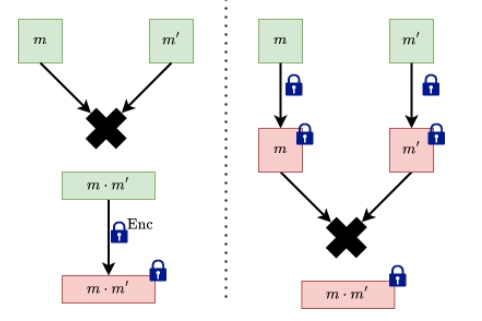

Before describing how we multiply two ciphertexts we need to reinterpret the decryption equation:
$$c_0 + c_1 \cdot s  \equiv m \bmod t$$
as a linear equation:
$$y = ax + b$$
in $s$.

If we look at adding two such linear equations in $s$ we obtain another linear equation in $s$:
$$c_0 + c_1 \cdot s + c'_0  + c'_1 \cdot s = \underbrace{(c_0 + c_0')}_{c^*_0}  + \underbrace{(c_1 + c'_1)}_{c^*_1} \cdot s$$

However, when multiplying two linear equations in $s$ we get a quadratic equation ($ax^2 + bx + c$) in $s$:

$$
\begin{align*}
\underbrace{(c_0 + c_1 \cdot s )}_{= m \bmod t} \cdot \underbrace{(c'_0 + c'_1 \cdot s )}_{= m' \bmod t} &= c_1 \cdot c'_1 \cdot s^2 + (c_0 \cdot c'_1 + c_1 \cdot c'_0) \cdot s +c_0 \cdot c'_0
\end{align*}
$$

We can define `mul` in the following way:
`mul(c, c') -> c*`

- $c^*_0 = c_0 \cdot c'_0$
- $c^*_1 = c_0 \cdot c'_1 + c_1 \cdot c'_0$
- $c^*_2 = c_1 \cdot c'_1$
- return $c^* = (c^*_0, c^*_1, c^*_2)$

**Remarks**

- Similarly, as in addition, the noise of the resulting ciphertext $c^*$ increases.
- We increase the number of ciphertext components by 1. This is not sustainable.
- Our decryption equation is linear, however after `mul` we have a quadratic decryption equation with 3 ciphertexts that doesn't play well with the our idea of linear decryption equation.

To solve the remarks the concept of **relinearization** is introduced.


_Intuition_: We want to transform the quadratic equation $c^*_0 + c^*_1 \cdot s + c^*_2 \cdot s^2$ in $s$ into some other linear equation $\hat c_0 + \hat c_1 \cdot \hat s$ in $\hat s$ for some other secret key $\hat s$.

In order to do this we need to give some extra information (a "hint") about the key $s$ that will help us get $\hat s$.

Consider the hint to be the pair:
$$(ek_0, ek_1) = ((a \cdot s + te) + s^2, -a)$$
This is very similar to how the public key is generated and we can use the `PubKeyGen -> (pk0, pk1)` to generate it:
$$(pk_0 + s^2, pk_1)$$
Intuitively, we use a RLWE sample to hide $s^2$.

Notice that:
$$ek_0 + ek_1 \cdot s = \cancel{a \cdot s} + e + s^2 - \cancel{a \cdot s} = s^2 + e$$

The easiest way to get the term $c^*_2 s^2$ from the above equation is to multiply it by $c^*_2$. However, $c^*_2$ is a random element in $R_q$ and it will yield some large noise $c^*_2e$. So we have to do something smarter.


### Key switching


Key switching is a variant of relinearization. We start with a ciphertext $c$.

**Idea**:  
Split the ciphertext into multiple "small" ciphertexts (for now think of small as the ciphertext polynomials having small coefficents). We can do this by decomposing the ciphertext coefficients into a small base $T$.

_Intuition_:  
To build an intuition, we can take the most common bases used in representing numbers:

- Base 10: $123_{10} = 3 \cdot 10^0 + 2 \cdot 10 ^1 + 1 \cdot 10^2$
- Base 2: $12_{10} = 1100_2 = 1 \cdot 2^3 + 1 \cdot 2^2 + 0 \cdot 2^1 + 0 \cdot 2^0$

Programmatically, this can be done by dividing the integer by the base $T$ _repeatedly_ and collecting the remainders.

In Python code:


In [3]:
from typing import List


def int2base(x: int, base: int) -> List[int]:
    digits = []
    while x > 0:
        q, r = divmod(x, base)
        digits.append(r)
        x = q
    return digits


In [4]:
print(int2base(123, 10))
print(int2base(12, 2))


[3, 2, 1]
[0, 0, 1, 1]


A ciphertext component $c \in R_q$ is a polynomial of degree less than $n$, with coefficients in $\{0,1,..,q-1\}$, which we denote as follows:
$$c(x) = c[0] + c[1]x + ... + c[n-1]x^{n-1}$$

We want to write the coefficients $(c[0], ..., c[n-1])$ in base $T$. Since any coefficient is less than $q$, this decomposition has at most $\lfloor \log_T q \rfloor + 1$ terms. For example $c[0] = \sum_{i=0}^{\lfloor \log_T q \rfloor} T^i c[0]^{(i)}$ where $c[0]^{(i)}$ is the corresponding digit $< T$ in the decomposition. Using these digits we can construct the polynomials $c^{(i)}$:
$$c^{(i)}(x) = c[0]^{(i)} + c[1]^{(i)}x + ... + c[n-1]^{(i)}x^{n-1}$$

Then using these polynomials we can decompose the original polynomial $c$:
$$c = \sum_{i=0}^{\lfloor \log_T q \rfloor} T^i  \cdot c^{(i)} \bmod q$$

The polynomials $c^{(i)}$ are elements of $R_T$ and for a reasonable small $T$ they have small coefficients ($< T$). For each one of them we generate the hints:
$$(ek_0^{(i)}, ek_1^{(i)}) = (a_i \cdot s + te_i + T^is^2, -a_i)$$
with $a_i \xleftarrow{R} R_q$ and $e_i \leftarrow \chi$.

Now we go back to our ciphertext $c^* = (c_0^*, c_1^*, c_2^*)$, the result of `EvalMul`. We decompose $c^*_2$ in the base $T$ and we get:
$$c^*_2 = \sum_{i=0}^{\lfloor \log_T q \rfloor} T^i  \cdot {c^*_2}^{(i)} \bmod q$$

Then we construct the new ciphertext $\hat c$ with the **two** components:

$$
\begin{align*}
\hat c_0 &= c^*_0 + \sum_{i=0}^{\lfloor \log_T q \rfloor} ek_0^{(i)} \cdot {c^*_2}^{(i)} = c^*_0 + \sum_{i=0}^{\lfloor \log_T q \rfloor} ((a_i \cdot s + te_i) + T^is^2 )\cdot {c^*_2}^{(i)}\\
\hat c_1 &= c^*_1 + \sum_{i=0}^{\lfloor \log_T q \rfloor} ek_1^{(i)} \cdot {c^*_2}^{(i)} = c^*_1 + \sum_{i=0}^{\lfloor \log_T q \rfloor} -a_i \cdot {c^*_2}^{(i)}
\end{align*}
$$

Using the above relations, we obtain the following linear equation:

$$\hat c_0 + \hat c_1 \cdot s = \underbrace{c^*_0 + c^*_1 \cdot s + c^*_2 \cdot s^2}_{m \cdot m'} + \underbrace{ \sum_{i=0}^{\lfloor \log_T q \rfloor} te_i \cdot {c^*_2}^{(i)}}_{\text{relinearization error}}$$
(the terms containing $a_i \cdot s$ from $\hat c_0$ and $-a_i \cdot s$ from $\hat c_1 \cdot s$ cancel out, $c^*_2$ is reconstructed and we are left with an error term).

Because the relinearization error is a multiple of $t$, it goes away when we decrypt and reduce $\bmod t$ as long as the relinearization error does not wrap $m^* = m\cdot m'$ around $q$.

**Remarks**

- We need to relinearize after a multiplication.
- A smaller $T$ means we have a smaller noise, but more relinearization keys are needed.
- $T$ is chosen based on what we want to optimize. We usually want to choose $T$ to introduce a noise around the size of the noise in the ciphertexts. Once the noise grows we can use $T^2$ or something else. We can also choose a big $T$ at the start (which introduces lots of starting noise) and we don't need to change it later.


### Modulus switching

**Task**:
You want to reduce the noise that accumulates in the ciphertext, after performing homomorphic operations. The modulus switching technique allows us to decrease the noise, to ensure the decryption is still correct after performing homomorphic operations. More analysis is provided in a dedicated section below.

**Idea**: The technique uses two moduli $Q, q$ with $q < Q$ and $q | Q$. This involves changing the ring where the ciphertexts live, $R_Q$, with a ring $R_q$, that is parametrized by the smaller modulus. When you perform this change, the coefficient ring $\mathbb Z_Q$ is "approximated" by some ring $\mathbb Z_q$, in the intuitive sense that the numbers become smaller (the numbers are scaled down by some factor). As we will see this means that the noise will be smaller in absolute value. Although, the noise will relatively stay the same, since $q < Q$, we mostly care about the magnitude of the noise, especially in multiplications.

You can perform this repeatedly with many moduli $\{q_0, q_1, ..., q_L\}$ with decreasing values to lower the noise after each multiplication.

The easiest way to do this is to scale down the ciphertext's components by $q / Q$ and **smartly round** in a way to keep the decryption equation correct. To ensure this, we want the scaling to keep the following propriety: $\tilde c_i = c_i \bmod t$ , where $\tilde c_i \approx (q / Q) c_i$ where $i \in \{0, 1\}$.

The two requirements that we want to have are

1. The decryption should be correct (decryption mod $Q$ should be the same as decryption mod $q$): $[c_0 + c_1 \cdot s]_Q = [\tilde c_0 + \tilde c_1 \cdot s]_q \bmod t$.
2. The noise scales down.

**Rounding**  
In order for the decryption to be correct we must adjust $c_i$ before scaling by $q / Q$. To do this we add a **small correction term** $\delta_i$ per component. We require $\delta_i$ to:

1. Only influence the error, hence $\delta_i \equiv 0 \bmod t$ (it will disappear when decrypting)
2. Make the ciphertext to be divisible by $Q / q \Rightarrow c_i + \delta_i \equiv 0 \bmod \dfrac Q q  \Rightarrow \delta_i \equiv -c_i \bmod \dfrac Q q$.

One easy choice to set the correction terms such that both properties hold is $\delta_i = t [-c_i t^{-1}]_{Q/q}$ where $t^{-1}$ is the inverse of $t$ modulo $Q / q$.

In the end, we define the components $\tilde c_i$ of the modulus switched ciphertext:
$$\tilde c_i = \dfrac q Q(c_i + \delta_i)$$

**Correctness**  
Now, let's check the decryption equation is actually correct. For a $k \in R$:

$$
\begin{align*}
[\tilde c_0 + \tilde c_1 \cdot s]_q
&= \tilde c_0 + \tilde c_1 \cdot s - kq \\
&= \dfrac q Q(c_0 + \delta_0) + \dfrac q Q (c_1 + \delta_1) \cdot s - kq \\
&= \dfrac q Q(c_0 + c_1 \cdot s + \delta_0 + \delta_1 \cdot s) - kq \\
&= \dfrac q Q([c_0 + c_1 \cdot s]_Q + kQ + \delta_0 + \delta_1 \cdot s) - kq \\
&= \dfrac q Q \underbrace{[c_0 + c_1 \cdot s]_Q}_{\equiv m \bmod t}  + \underbrace{\dfrac q Q (\delta_0 + \delta_1 \cdot s)}_{\equiv 0 \bmod t} + kq - kq \\
&\equiv \dfrac q Q m \bmod t
\end{align*}
$$

When doing $c_0 + c_1 \cdot s = [c_0 + c_1 \cdot s]_Q + kQ$
we mention that $k$ is the same as in $[\tilde c_0 + \tilde c_1 \cdot s]_q = \tilde c_0 + \tilde c_1 \cdot s - kq$ under some conditions (see lemma 1 from [here](https://eprint.iacr.org/2011/277.pdf)).

In the end we decrypt $\dfrac q Q m$ instead of $m$. In practice this can be solved by multiplying by $Q/q$ before encryption or after decryption, or to take $Q/q \equiv 1 \bmod t$ (however such a $Q/q$ can be harder to find).


### Key switching v2


Now that we know about modulus switching we introduce a second version to do key switching in BGV. Recall that the key switching technique is used in relinearization, for decreasing the size of the ciphertext obtained in multiplication.

**Idea**: Given two moduli $q, Q$ with $q < Q$ and $q | Q$, we start with elements in $R_q$ and we make a detour in a ring $R_Q$ with a bigger modulus $Q$ where we perform our relinearization. Then we perform modulus switching to go back to our small ring $R_q$.

We generate the _hint_:
$$ (ek_0, ek_1) = (a \cdot s + te + \frac Q q s ^ 2, -a) \bmod Q$$

Recall that $c^* = (c^*_0, c^*_1, c^*_2)$ is the result of the `mul`. Then we compute the components of the new ciphertext $\hat c$:

$$
\begin{align*}
\hat c_0 &= \frac Q q c_0^* + c_2^* \cdot ek_0 \bmod Q\\
\hat c_1 &= \frac Q q c_1^* + c_2^* \cdot ek_1 \bmod Q
\end{align*}
$$

Lastly, we scale them both using modulus switching: $\hat c_i = \dfrac q Q (\hat c_i + \delta_i)$ with $\delta_i = t[-c_i t^{-1}]_{Q/q}$, like before.

The relinearization equation looks like this:
$$\hat c_0 + \hat c_1 \cdot s = \underbrace{c_0^* + c_1^* \cdot s + c_2^* \cdot s^2}_{m\cdot m'} + \underbrace{\dfrac q Q (tc_2^* \cdot e + \delta_0 + \delta_1 \cdot s)}_{\text{relinearization error}}$$

Because the relinearization error is a multiple of $t$ (remember that we chose $\delta_i$ to be multiples of $t$ too, to not influence the error), it will go away when we decrypt and reduce $\bmod t$ as long as the relinearization error does not wrap $m^* = m\cdot m'$ around $q$.

**Correctness**

$$
\begin{align*}
\hat c_0 + \hat c_1 \cdot s
&= \dfrac q Q \left( \frac Q q c_0^* + c_2^* \cdot ek_0 + \delta_0 \right) + \left(\frac q Q \left ( \dfrac Q q c_1^*  + c_2^* \cdot ek_1 \right) + \delta_1 \right)\cdot s \\
&= \dfrac q Q \left( \frac Q q c_0^* + c_2^* \cdot \left( a \cdot s + te + \frac Q  q s ^ 2 \right) + \delta_0 \right) + \left(\frac q Q \left ( \dfrac Q q c_1^*  + c_2^* \cdot (-a)\right)  + \delta_1 \right) \cdot s \\
&= c_0^* + c_1^* \cdot s + c_2^* \cdot s^2 + \dfrac q Q (tc_2^* \cdot e + \delta_0 + \delta_1 \cdot s) \\
&= mm' \bmod t
\end{align*}
$$


## Noise analysis

Relevant papers:

- [Ilia Iliashenko thesis](https://www.esat.kuleuven.be/cosic/publications/thesis-316.pdf)
- [CS15](https://eprint.iacr.org/2015/889.pdf)
- [Evaluating the effectiveness of heuristic worst-case noise analysis in FHE](https://eprint.iacr.org/2019/493.pdf)
- [GHS](https://eprint.iacr.org/2012/099.pdf)
- [HElib](https://eprint.iacr.org/2022/706.pdf)


### Measuring Noise


In this section we will analyze the noise for the operations we described above. We will denote with $B$ an upper bound of some noise sampled from $\chi$. For example if $B$ is the bound for the noise hidden in any of the 2 ciphertexts, then addition will have $2B$ and multiplication $B^2$.

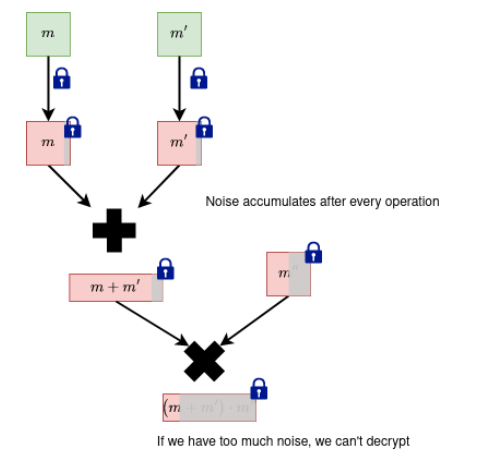

_Intuition_: To measure noise we want to see "how much" a polynomial can impact operations (such as addition, multiplication). To measure the latter, we can bound the polynomial with a number that represents the biggest impact it can have when doing some operation. For example, we can look at the biggest coefficient in absolute value.

"Measuring" polynomials:

1. **Infinity norm**: $\|a\|_\infty = \max{a_i}$. The value of the biggest coefficient in absolute value.
2. **Canonical norm**: $\can a$

**Canonical embedding**  
We have the quotient polynomial $X^n + 1$ of $R$ which has the complex roots $\{\zeta_0, \dots, \zeta_{n-1}\}$ with $\zeta_i^n = -1 \Rightarrow \zeta_i^{2n} = 1$. Note that rasing $\zeta_i$ to odd power yields another complex root of $X^n + 1$. This means that we can take any root $\zeta \in \{\zeta_0, \dots, \zeta_{n-1}\}$ and generate $\{\zeta, \zeta^3, \dots, \zeta^{2n-1}\} = \{\zeta_0, \dots, \zeta_{n-1}\}$

Then we take a polynomial $a \in R$:
$$a(X) = a_0 + a_1X + ... a_{n-1}X^{n-1}$$
or in vector form: $$a = (a_0, a_1, ..., a_n)$$
and we evaluate $a$ in every root $\zeta_i$. This leads to a vector $\left(a(\zeta_0), ... a(\zeta_{n-1})\right)$. We call this vector the **canonical embedding**.  
Notation: we denote the evaluation $a(\zeta_i)) = \sigma_i(a(X)) = \sigma_i(a)$ and the canonical embedding with $\sigma: R \to \mathbb C^n$, $\sigma(a) = (\sigma_0(a), ... \sigma_n(a))$

**Canonical norm**  
Since now we have a new vector represented by the canonical embedding, we consider its norm: the **canonical norm** $\can a = \|\sigma(a)\|_\infty$. This norm has the propriety that $\can {ab} \leq \can a \can b$

There is a relationship between this norms: $\|a\|_{\infty} \leq c_m\cdot \can a$ for some constant $c_m$, which is $1$ when $n$ is a power of $2$.

In practice, the canonical norm is used to compute the noise bounds, because it provides a better heuristic approximation to the maximum noise.  
_Intuition_:

- computing noise using the infinity norm we obtain the maximum possible noise, ignorning the distributions the polynomials were sampled from.
- Ex: If we sample the secret key from $\{-1, 0, 1\}^n$ the norm always considers the worst possible case is $s = (1, 1, ..., 1)$ with the norm $n$. However, it's very unlikely that we will get such an $s$.

**Noise bounds**  
Suppose we choose $a \in R$ from one of the distributions (discrete gaussian, random, ternary). Let $V_a$ be the variance of each coefficient $(a_0, ... a_n)$ in $a$. Then we get the random variable $a(\zeta)$ which has the the variance $nV_a$ ($n$ elements of $V_a$ variance). Then the canonical embedding is bounded by:
$$ \can a \leq D \sqrt{n V_a}$$
for some positive number $D$. This $D$ depends on the distribution that we choose with the property that the probability of the random variable exceeding this bound is insignifiant.

For two polynomials $a, b \in R$ and some constant $k$ with variances $V_a, V_b$ we have the following relations

- $V_{a+b} = V_a + V_b$
- $V_{ka} = k^2V_a$
- $V_{a \cdot b} = nV_aV_b$

For the distributions that we work with we have the **coefficient** variances:

- Discrete gaussian distribution with standard deviation $\sigma: \ V_{\mathcal {DG}} = \sigma^2$.
- Ternary distribution: $V_3 = 2/3$.
- Uniform distribution with coefficients in $\mathbb Z_q: \ V_q \approx q^2 / 12$


### Noise for operations


When doing operations (such as addition, multiplication) with noisy ciphertexts, the total noise accumulates. In the end we want our decryption to be correct. However, this can only happen if the accumulated noise does not exceed some **bound**.

_Intuition_: We want to "measure" this accumulated noise by looking at "how much" a polynomial can impact an operation it's involved in. For example, we can analyze the impact of the polynomials $e_i$ which represent the RLWE noise or of the secret $s$. We can represent the polynomial's impact with a number.

We can "measure" the impact of the polynomials using the:

1. **Infinity norm**: $\|a\|_\infty = \max{|a_i|}$, which is the value of the biggest coefficient in absolute value.
2. **Canonical norm**: $\can a$. In order to define it we use the so called **canonical embedding** of the polynomial.

While the infinity norm is easy to understand, the canonical embedding is a bit more mathematically involved. Instead of searching for a way to measure the impact of a polynomial $a \in R$, we transfer the polynomial in another space, such as $\mathbb C^n$, and we search for a better measure there.

Recall that we work with polynomials from the ring $R_q = \mathbb Z_q[X]/(X^n + 1)$ with $n$ a power of $2$.

**Canonical embedding**  
We have the quotient polynomial $X^n + 1$ of $R$ which has the complex roots $\{\zeta_0, \dots, \zeta_{n-1}\}$ with $\zeta_i^n = -1 \Rightarrow \zeta_i^{2n} = 1$.  
Then we take a polynomial $a \in R$:
$$a(X) = a_0 + a_1X + ... a_{n-1}X^{n-1}$$
and we evaluate $a$ in every root $\zeta_i$. This leads to a vector $\left(a(\zeta_0), ... a(\zeta_{n-1})\right) \in \mathbb C^n$. We call this vector the **canonical embedding** of $a$.  
The [canonical embedding](https://eprint.iacr.org/2012/230.pdf) is defined as $$\sigma: R \to \mathbb C^n,
\quad \sigma(a) = \left(a(\zeta_0), ... a(\zeta_{n-1})\right)$$

**Canonical norm**  
Since now we have obtained a new vector in $\mathbb C^n$ we can look at its infinity norm and define the **canonical norm** $\can a = \|\sigma(a)\|_\infty$.

In practice, the canonical norm is used to compute the noise bounds, because it provides a better decryption noise bound.

1. There is a relationship between these norms: $\|a\|_{\infty} \leq c_{2n}\cdot \can a$ for some constant $c_{2n}$, which is $1$ when $n$ is a power of $2$ (see [this](https://eprint.iacr.org/2011/535.pdf)). With this inequality in mind, it suffices to assure correct decryption by setting the canonical norm of the noise to be less than $q/2$.
2. When doing multiplications, the noise bound offered by the canonical norm increases slower than the bound offered by the infinity norm. We have these two inequalities:
   $$
   \begin{align*}
   \|ab\|_\infty &\leq \gamma\|a\|_\infty \|b\|_\infty  \\
   \can {ab} &\leq \can a \can b
   \end{align*}
   $$
   where $\gamma > 1$ is the so-called _expansion factor_ of the ring $R$. For more details, see [this](https://escholarship.org/content/qt0141w93p/qt0141w93p.pdf).

**Noise bounds**  
Suppose we choose $a \in R$ with coefficients sampled independently from one of the distributions (discrete Gaussian, random, ternary). Let $V_a$ be the variance of each coefficient $(a_0, ... a_n)$ in $a$. In [Ilia Iliashenko's thesis](https://www.esat.kuleuven.be/cosic/publications/thesis-316.pdf) and in the [Finding and Evaluating Parameters for BGV](https://eprint.iacr.org/2022/706.pdf) paper it's shown that we can choose a number $D$ such that
$$ \can a \leq D \sqrt{n V_a}$$
holds with overwhelming probability. In practice, we set $D = 6$.

When analysing the noise growth we'll make use of the following proprieties. For two polynomials $a, b \in R$ with variances $V_a, V_b$ and some constant $k$ we have:

- $V_{a+b} = V_a + V_b$ ,
- $V_{ka} = k^2V_a$,
- $V_{a \cdot b} = nV_aV_b$.

For the distributions that we work with we have the **coefficient** variances:

- Discrete Gaussian distribution with standard deviation $\sigma: \ V_{\mathcal {DG}} = \sigma^2$.
- Ternary distribution: $V_3 = 2/3$.
- Uniform distribution with integer coefficients in $(-q/2, q/2]: \ V_q \approx q^2 / 12$.

### Noise for operations

We now have the building blocks (starting values and operations) to analyse the noise for each operation. The goal of analysing the noise buildup is to choose the scheme parameters such that the scheme properties (fhe, decryption) hold and the scheme remains secure. Following the paper [Finding and Evaluating Parameters for BGV](https://eprint.iacr.org/2022/706.pdf) we have:

**Fresh ciphertext noise**  
In order to make sure the decryption is correct we must make sure the error
$$v = c_0 + c_1 \cdot s= \underbrace{t(e \cdot u + e_0 + e_1 \cdot s)}_{r}+ m = r + m \bmod q$$
does not wrap around the modulus (i.e $\|v\|_{\infty} \leq c_{2n}\can v \leq q/2$ ). The message $m$ is thought to come uniformly from $R_t$.

Recall that

- The errors $e, e_0, e_1$ come from a discrete Gaussian => $V_e = V_{e_0} = V_{e_1} = \sigma^2$.
- The secret $s$ and $u$ come from a ternary distribution => $V_s = V_u = 2/3$.
- The message $m$ comes from $R_t$ and we assume that the coefficients are uniformly distributed in $\mathbb Z_t$ => $V_m = t^2 / 12$.

$$
\begin{align*}
V_v &= V_{m + t(e\cdot u + e_0 + e_1 \cdot s)} \\
&= V_m + t^2V_{e \cdot u + e_0 + e_1 \cdot s}  \\
&= \dfrac {t^2}{12} + t^2 \left (n\sigma^2 \dfrac 2 3 + \sigma ^ 2 + n\sigma^2 \dfrac 2 3 \right)  \\
&= t^2 \left( \dfrac 1 {12} + \sigma^2 \left( \dfrac 4 3 n + 1 \right) \right)
\end{align*}
$$

Hence:
$$\can v \leq D\sqrt {nV_v}$$

The parameters for the scheme and distributions, $q, t, \sigma, n$, are chosen such that the decryption is correct.

**Addition**  
For two ciphertexts $(c, c')$ encrypting $(m, m')$ we have the corresponding errors $(v, v')$. The error after ciphertext addition is $v_{\text{add}}$.

If we use the decryption equation we have
$$v_{\text{add}} = v + v' = (c_0 + c_1 \cdot s) + (c_0' + c_1' \cdot s) = r + m + r' + m' \bmod q$$

We have $m + m' = [m + m']_t + gt$ with $g \in R$ and $\|g\|_{\infty} = 1$ (because both $\|m\|_{\infty}, \|m'\|_{\infty} < t / 2$). By replacing in the equation above we obtain:
$$v + v' = [m + m']_t + r + r' + gt \bmod q$$

We see that the noise $r + r' + gt$ grows linearly.

Finally, using the canonical norm we have the following:
$$\can {v_{\text{add}}} \leq \can v + \can {v'}$$

**Multiplication**  
Similarly for multiplication, if we use the decryption equation we have:
$$v_{\text{mul}} = v \cdot v' = (c_0 + c_1 \cdot s) \cdot (c_0' + c_1' \cdot s) = (r + m) + (r' + m') = mm' + mr' + m'r + rr' \bmod q$$

If we look at the error term $mr' + m'r + rr'$ we see that in the leading term $rr'$ we multiply the noises, therefore the noise grows quadratically.

Using the canonical norm, we have:
$$\can {v_{\text{mul}}} \leq \can v\can {v'}$$

**Modulus switching**  
For modulus switch we scale the noise down and then we add the small error that comes with the correction terms $\delta_0, \delta_1$.
Recall that

- We set $\delta_i = t[-c_it^{-1}]_{Q/q}$. We assume the terms $[-c_it^{-1}]_{Q/q}$ are uniformly distributed mod $Q / q$, then multiplied by $t$ => $V_{\delta_0} = V_{\delta_1} = \dfrac {t^2Q^2} {12q^2}$.

$$v_{\text{switch}} = [\tilde c_0 + \tilde c_1 \cdot s]_q = \dfrac q Q [c_0 + c_1 \cdot s]_Q  + \dfrac q Q (\delta_0 + \delta_1 \cdot s) = \dfrac q Q v  + \dfrac q Q (\delta_0 + \delta_1 \cdot s)$$

Using the canonical norm we get:
$$\can {v_{\text{switch}}} \leq \dfrac q Q \can v + \dfrac q Q \can {\delta_0 + \delta_1 \cdot s} \leq \dfrac q Q \can v + Dt\sqrt{\dfrac n {12} \left (1 + \dfrac 2 3 n \right)}$$

We can see that the noise is scaled down by almost $q / Q$.

**Key switching - Base decomposition**  
In relinearization we deal with $c_0 + c_1 \cdot s + c_2 \cdot s^2$. Here we decompose $c_2 \cdot s^2$ in base $T$ and hide the _hints_ about $s^2$ using RingLWE-like samples involving errors $e_i$. Remember from key switching technique using base decomposition that we have a relinearization error: $\sum_{i=0}^{\lfloor \log_T q \rfloor} te_i \cdot {c^*_2}^{(i)}$. The variance of any term $te_i \cdot {c^*_2}^{(i)}$ from the sum is $V_{t e_i \cdot {c^*_2}^{(i)}}$.

Recall that

- The errors $e_i$ come from a discrete Gaussian distribution => $V_{e_i}= \sigma^2$.
- We can assume that the polynomials in base $T$ behave like random polynomials extracted from $R_T$ => $V_{{c^*_2}} = T^2 / 12$.

$$v_{\text{ks}} = \underbrace{c^*_0 + c^*_1 \cdot s + c^*_2 \cdot s^2}_{v_{\text{mul}}} +  \sum_{i=0}^{\lfloor \log_T q \rfloor} te_i \cdot {c^*_2}^{(i)}$$

If we use the canonical norm:

$$
\begin{align*}
\can {v_{\text{ks}}} & \leq \can {v_{\text{mul}}} + D\sqrt{n \log_T (q)V_{t e_i \cdot {c^*_2}^{(i)}}} \\
&= \can {v_{\text{mul}}} + Dt\sqrt{n^2 \log_T (q)V_{e_i} V_{{c^*_2}^{(i)}}}  \\
&= \can {v_{\text{mul}}} + DtnT\sqrt{ \log_T (q)\dfrac {\sigma^2} {12}}
\end{align*}
$$

**Key switching - Modulus switch**  
In the relinearisation version that employs modulus switching, we have the following error term: $\dfrac q Q (tc_2^* \cdot e + \delta_0 + \delta_1 \cdot s)$.
Recall that:

- The ciphertext component $c_2^*$ comes from $R_q$ => $V_{c_2^*} = q^2 / 12$.
- The errors $e$ comes from a discrete Gaussian => $V_{e}= \sigma^2$.
- The secret $s$ comes from a ternary distribution => $V_{s}= 2/3$.
- We set $\delta_i = t[-c_it^{-1}]_{Q/q}$. We assume the terms $[-c_it^{-1}]_{Q/q}$ are uniformly distributed mod $Q / q$, then multiplied by $t$ => $V_{\delta_0} = V_{\delta_1} = \dfrac {t^2Q^2} {12q^2}$.

$$v_{\text{ks}} = \underbrace{c_0^* + c_1^* \cdot s + c_2^* \cdot s^2}_{v_{\text{mul}}} + \dfrac q Q (tc_2^* \cdot e + \delta_0 + \delta_1 \cdot s)$$

The variance of this error term is:

$$
\begin{align*}
V_{\frac q Q (tc_2^* \cdot e + \delta_0 + \delta_1 \cdot s)}
&= \left(\frac q Q \right)^2 (t^2 nV_{c_2^*}V_e + V_{\delta_0} + nV_{\delta_1}V_s) \\
&= \left(\frac q Q \right)^2 \left(t^2  n \frac {q^2} {12} \sigma^2 +  \dfrac {t^2Q^2} {12q^2} + n  \dfrac {t^2Q^2} {12q^2} \dfrac 2 3\right) \\
&= \left(\frac q Q \right)^2 \left(t^2  n \frac {q^2} {12} \sigma^2 \right)  +\dfrac {t^2} {12} + n  \dfrac {t^2} {12} \dfrac 2 3 \\
&= \left(\frac q Q \right)^2 \left(t^2  n \frac {q^2} {12} \sigma^2 \right)  +\dfrac {t^2} {12} \left(1+ \dfrac 2 3 n \right)
\end{align*}
$$

Now we can bound:

$$
\begin{align*}
\can {v_{\text{ks}}}
& \leq \can {v_{\text{mul}}} + D\sqrt{n \left(\frac q Q \right)^2 \left(t^2  n \frac {q^2} {12} \sigma^2 + \frac {t^2} {12} \left(1+ \dfrac 2 3 n\right) \right)} \\
& \leq \can {v_{\text{mul}}} + D \frac q Q t\sqrt{n \left(n \frac{q^2} {12} \sigma^2 + \frac {1} {12} \left(1+ \dfrac 2 3 n\right) \right)}
\end{align*}
$$


# Code

We provide a proof of concept implementation, in Python. The aim of the code is to mirror the equations easily. This means that if we see $a \cdot s + e$ in the theory part we prefer to see `a * s + e` in code instead of `polyadd(polymul(a, s), e)`.

> DISCLAIMER: The code should be used for educational purposes only, and never in production.

We represent polynomials using a class: `QuotientRingPoly`. Every polynomial is defined by three attributes:

- `coef: np.ndarray` - Vector of the polynomial's coefficients. `coef[-1]` is the free coefficient, `coef[0]` is the leading coefficient. It's always padded to have `n` elements.
- `coef_modulus: int` - Modulus of the ring where its coefficients live in.
- `poly_modulus: int | np.ndarray` - Modulus of the polynomial ring where it belongs: `X^n + 1`

`QuotientRingPoly` has the `._reduce(self)` method which reduces any polynomial to an element in the ring.

We overloaded the operators `+, -, *, //, %`:

- Operators work between two `QuotientRingPoly` using the default polynomial operation rules.
- Operators work between a `QuotientRingPoly` and an `int | float` coefficient-wise.

The attributes `coef` and `coef_modulus` can be assigned too. After assigning, the `_reduce()` method will be called. This is helpful to easily change the ring of the polynomial.

**Remarks**

- To work with big integers, we use the python built in `int` class. To use this with numpy we set `dtype = object` for every array creation.
- We have helper functions `roundv` and `intv` (round vector, int vector) that vectorize the `round` and `int` operations, allowing us to help with rounding and converting vector elements to python's builtin `int` class.


In [1]:
import math
import random
from typing import List, Union

import numpy as np
from Crypto.Util.number import getPrime, getRandomNBitInteger
from numpy.polynomial.polynomial import polyadd, polymul


In [2]:
def polydiv(poly1, poly2):
    """
    Divide poly1 by poly2 and return the quotient and remainder as numpy arrays
    GENERATED BY CHATGPT
    """
    # Ensure that the degree of the second polynomial is less than or equal to the degree of the first polynomial
    while len(poly1) >= len(poly2):
        # Compute the quotient of the leading terms of the two polynomials
        quotient = poly1[-1] // poly2[-1]

        # Compute the product of the quotient and the second polynomial shifted to align with the leading term of the first polynomial
        product = np.zeros(len(poly1), dtype=object)
        product[-len(poly2) :] = quotient * poly2

        # Compute the difference between the first polynomial and the product
        difference = poly1 - product

        # Remove any leading zeros from the difference
        while len(difference) > 0 and difference[-1] == 0:
            difference = difference[:-1]

        # Set the difference as the new value of the first polynomial
        poly1 = difference

    # Return the quotient and remainder as numpy arrays
    quotient = np.zeros(len(poly1) + len(poly2) - 1, dtype=object)
    quotient[-len(poly1) :] = poly1
    remainder = poly1
    return quotient, remainder


In [18]:
def roundv(array):
    return np.array([round(a) for a in array], dtype=object)


def intv(array):
    return np.array([int(a) for a in array], dtype=object)

In [3]:
def int2base(x: int, base: int) -> List[int]:
    digits = []
    while x > 0:
        q, r = divmod(x, base)
        digits.append(r)
        x = q
    return digits


In [4]:
def mod_center(x, m: int, left_closed: bool = True):
    # [-m // 2, m // 2)
    if left_closed:
        return (x + m // 2) % m - m // 2
    # (-m // 2, m // 2]
    else:
        return (x + m // 2 - 1) % m - m // 2 + 1

In [5]:
print(mod_center(5, 10))
print(mod_center(5, 10, left_closed=False))


-5
5


## QuotientRingPoly


In [13]:
def init_poly_modulus(poly_modulus: Union[int, np.array]) -> np.array:
    # If it's int, let it be x ^ poly_modulus + 1, else just init the poly modulus
    if isinstance(poly_modulus, int):
        poly_modulus = np.array([1] + [0] * (poly_modulus - 1) + [1], dtype=object)
    else:
        poly_modulus = poly_modulus
    return poly_modulus


def untrim_seq(poly: np.array, degree: int) -> np.array:
    # Add 0s to the higher powers until we reach degree
    coef = np.append(poly, [0] * (degree - len(poly)))
    return coef

In [6]:
class QuotientRingPoly:
    def __init__(
        self,
        coef: np.array,
        coef_modulus: int,
        poly_modulus: Union[int, np.array],
    ):
        self._coef_modulus = coef_modulus
        self._poly_modulus = init_poly_modulus(poly_modulus)
        self._coef = coef
        # Reduce mod coef and mod poly.
        self.degree = len(poly_modulus) - 1
        self._reduce()

    def _reduce(self):
        self._coef = roundv(self._coef)
        self._coef = mod_center(self._coef, self.coef_modulus)
        _, self._coef = polydiv(self._coef, self.poly_modulus)
        self._coef = mod_center(self._coef, self.coef_modulus)

        # Extend the 0s to match the degree
        self._coef = untrim_seq(self._coef, self.degree)
        # Transform the coeffs to int, sanity check.
        self._coef = roundv(self._coef)

    def _check_qring(self, other):
        if (
            any(self.poly_modulus != other.poly_modulus)
            or self.coef_modulus != other.coef_modulus
        ):
            raise ValueError("Polynomials are not in the same Quotient Ring")

    def __neg__(self):
        return QuotientRingPoly(-self._coef, self.coef_modulus, self.poly_modulus)

    def __add__(self, other):
        # Perform addition. If other is int, add to coeff
        if isinstance(other, (int, float)):
            res_coef = self.coef + other
            res = QuotientRingPoly(res_coef, self.coef_modulus, self.poly_modulus)
        else:
            self._check_qring(other)
            res_poly = polyadd(self._coef, other.coef)
            res = QuotientRingPoly(res_poly, self.coef_modulus, self.poly_modulus)
        return res

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        if isinstance(other, (int, float)):
            res_coef = self.coef * other
            res = QuotientRingPoly(res_coef, self.coef_modulus, self.poly_modulus)
        else:
            self._check_qring(other)
            # print(np.polymul(self.poly.coef, other.poly.coef))
            res_coef = polymul(self._coef, other.coef)
            res = QuotientRingPoly(res_coef, self.coef_modulus, self.poly_modulus)
        return res

    def __floordiv__(self, other):
        if isinstance(other, (int, float)):
            res_coef = self.coef // other
            res = QuotientRingPoly(res_coef, self.coef_modulus, self.poly_modulus)
        else:
            self._check_qring(other)
            q, _ = polydiv(self.poly, other.poly)
            res = QuotientRingPoly(q, self.coef_modulus, self.poly_modulus)
        return res

    def __mod__(self, other):
        if isinstance(other, (int, float)):
            res_coef = self.coef % other
            res = QuotientRingPoly(res_coef, self.coef_modulus, self.poly_modulus)
        else:
            self._check_qring(other)
            _, r = polydiv(self.poly, other.poly)
            res = QuotientRingPoly(r, self.coef_modulus, self.poly_modulus)
        return res

    def __eq__(self, other):
        return (
            all(self.poly_modulus == other.poly_modulus)
            and self.coef_modulus == other.coef_modulus
            and all(self._coef == other.coef)
        )

    def copy(self) -> "QuotientRingPoly":
        return QuotientRingPoly(self.coef, self.coef_modulus, self.poly_modulus)

    @property
    def poly_modulus(self):
        return self._poly_modulus.copy()

    @property
    def coef_modulus(self):
        return self._coef_modulus

    @coef_modulus.setter
    def coef_modulus(self, value):
        self._coef_modulus = value
        self._reduce()

    @property
    def coef(self):
        return self._coef

    @coef.setter
    def coef(self, value):
        self._coef = value
        self._reduce()

    def __repr__(self):
        r = f"{self.coef}, {self.coef_modulus}, {self.poly_modulus}"
        return r

In [10]:
def random_binary_poly(
    coef_modulus: int, poly_modulus: Union[int, np.array]
) -> QuotientRingPoly:
    """Generate a random binary polynomial in the given quotient ring."""
    poly_modulus = init_poly_modulus(poly_modulus)
    size = len(poly_modulus) - 1
    coef = np.random.choice([0, 1], size=size, dtype=object)
    return QuotientRingPoly(coef, coef_modulus, poly_modulus)


def random_ternary_poly(
    coef_modulus: int, poly_modulus: Union[int, np.array]
) -> QuotientRingPoly:
    """Generate a random ternary polynomial in the given quotient ring."""
    poly_modulus = init_poly_modulus(poly_modulus)
    size = len(poly_modulus) - 1

    # 0 with 1/2 chance, -1 or 1 with 1/2 chance
    # coef = np.random.randint(-1, 2, size, dtype=int)
    coef = np.random.choice(
        np.array([-1, 0, 1], dtype=object), size=size, p=[1 / 4, 1 / 2, 1 / 4]
    )
    return QuotientRingPoly(coef, coef_modulus, poly_modulus)


def random_uniform_poly(
    coef_modulus: int,
    poly_modulus: Union[int, np.array],
    high=None,
) -> QuotientRingPoly:
    """Generate a random polynomial with discrete coefficients uniformly distributed in the given quotient ring."""

    if high is None:
        high = coef_modulus - 1
    poly_modulus = init_poly_modulus(poly_modulus)
    size = len(poly_modulus) - 1
    coef = np.array([random.randrange(0, high) for _ in range(size)], dtype=object)
    # coef = np.random.randint(0, coef_modulus, size, dtype=object)
    return QuotientRingPoly(coef, coef_modulus, poly_modulus)


def random_normal_poly(
    coef_modulus: int,
    poly_modulus: Union[int, np.array],
    mu: float = 0,
    std: float = 3.8,
) -> QuotientRingPoly:
    """Generate a random polynomial with discrete coefficients extracted from a normal distribution in the given quotient ring."""
    poly_modulus = init_poly_modulus(poly_modulus)
    size = len(poly_modulus) - 1
    coef = np.array([round(random.gauss(mu, std)) for _ in range(size)], dtype=object)
    return QuotientRingPoly(coef, coef_modulus, poly_modulus)

## Encryption scheme


In [72]:
def gen_secret_key(coef_modulus: int, poly_modulus: np.ndarray):
    # Draw the secret
    s = random_ternary_poly(coef_modulus, poly_modulus)
    return s


def gen_public_key(
    sk: QuotientRingPoly,
    coef_modulus: int,
    poly_modulus: np.ndarray,
    plaintext_modulus: int,
):
    # Generate noise e
    e = random_normal_poly(coef_modulus, poly_modulus)
    # Generate unifrom poly a
    a = random_uniform_poly(coef_modulus, poly_modulus)
    # RLWE instance b
    b = a * sk + e * plaintext_modulus
    return b, -a


def encrypt(
    msg: QuotientRingPoly,
    pk0: QuotientRingPoly,
    pk1: QuotientRingPoly,
    coef_modulus: int,
    poly_modulus: np.ndarray,
    plaintext_modulus: int,
):
    u = random_ternary_poly(coef_modulus, poly_modulus)
    e0 = random_normal_poly(coef_modulus, poly_modulus)
    e1 = random_normal_poly(coef_modulus, poly_modulus)
    # Mask the message with a rlwe instance (b * r + te)
    c0 = pk0 * u + e0 * plaintext_modulus + msg
    c1 = pk1 * u + e1 * plaintext_modulus
    return c0, c1


def decrypt(
    c0: QuotientRingPoly,
    c1: QuotientRingPoly,
    sk: QuotientRingPoly,
    plaintext_modulus: int,
    return_noise: bool = False,
):
    msg = c0 + c1 * sk
    noise = np.max(np.abs(msg.coef))
    msg = msg % plaintext_modulus

    if return_noise:
        msg_not_reduced = np.max((c0 + c1 * sk).coef)
        # t = mod_center(polymul(c0.coef, sk.coef), c0.coef_modulus)
        # t = mod_center(polyadd(c1.coef, t), c0.coef_modulus)
        # _, t = polydiv(t, c0.poly_modulus)
        # msg_not_reduced = mod_center(t, c0.coef_modulus)
        noise = np.max(np.abs(msg_not_reduced))

        return msg, noise
    else:
        return msg

In [73]:
n = 2**4
# q
coef_modulus = getRandomNBitInteger(32)
# coef_modulus = 874
# coef_modulus = getrandbits(12)
plaintext_modulus = 7

poly_modulus = init_poly_modulus(n)
print(coef_modulus)
print(poly_modulus)


2744103875
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [74]:
# Generate secret key
sk = gen_secret_key(coef_modulus, poly_modulus)
sk


[-1 0 -1 0 -1 0 -1 -1 1 0 0 0 -1 0 0 0], 2744103875, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

In [75]:
# Generate public key pair
pk0, pk1 = gen_public_key(sk, coef_modulus, poly_modulus, plaintext_modulus)
pk0, pk1


([238425574 -1257629307 825500214 84007602 1317848945 256145851 -364086073
  1195284689 -237348791 1318794678 939987757 -1062427938 -1205247825
  886989323 -489333075 730514391], 2744103875, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1],
 [-1269945140 -577333119 1030702326 1302097291 -72504559 135647132
  -261892896 -566404704 -1176855220 170050901 845883326 927584865 449410449
  1330631429 -1333962120 354704240], 2744103875, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1])

In [76]:
# Generate random small message in R_t
msg = random_uniform_poly(coef_modulus, poly_modulus, high=plaintext_modulus)
print(msg.coef)


[6 1 3 3 4 1 0 0 3 4 6 2 1 5 2 2]


In [77]:
# Encrypt the message into two ciphertexts
c0, c1 = encrypt(msg, pk0, pk1, coef_modulus, poly_modulus, plaintext_modulus)
c0, c1


([-737558948 -713379070 694192576 213181798 16958402 -1246650270 429237533
  -842237688 1261468670 -373705889 -871140245 -598673598 254778709
  -1329147095 -578799095 -908134074], 2744103875, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1],
 [811902 -877588556 1098457073 -1188198461 -1237157618 1217140792
  -1237039651 1168443940 -962051475 -1354042542 -1011787558 -4874771
  1010546968 -551008631 -375343779 -1167722027], 2744103875, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1])

In [78]:
# Decrypt the message and return the noise
msg_decr, noise = decrypt(c0, c1, sk, plaintext_modulus, return_noise=True)


In [79]:
print(msg_decr.coef.astype(int))
print(msg.coef.astype(int))


[6 1 3 3 4 1 0 0 3 4 6 2 1 5 2 2]
[6 1 3 3 4 1 0 0 3 4 6 2 1 5 2 2]


In [80]:
noise < coef_modulus // 2


True

## FHE


In [81]:
def add(c0, c1, c0_, c1_):
    return c0 + c0_, c1 + c1_


In [82]:
def mul(c0, c1, c0_, c1_):
    return c0 * c0_, c0 * c1_ + c1 * c0_, c1 * c1_


def decrypt_quad(c0, c1, c2, sk, plaintext_modulus, return_noise: bool = False):
    # Evaluate the quadratic equation
    msg = c0 + c1 * sk + c2 * sk * sk
    noise = np.max(np.abs(msg.coef))
    msg = msg % plaintext_modulus

    if return_noise:
        return msg, noise
    else:
        return msg


In [83]:
n = 2**4
# q
coef_modulus = getRandomNBitInteger(32)
# coef_modulus = 874
# coef_modulus = getrandbits(12)
plaintext_modulus = 7

poly_modulus = init_poly_modulus(n)
print(coef_modulus)
print(poly_modulus)


2836167622
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [84]:
sk = gen_secret_key(coef_modulus, poly_modulus)
pk0, pk1 = gen_public_key(sk, coef_modulus, poly_modulus, plaintext_modulus)


In [85]:
msg = random_uniform_poly(coef_modulus, poly_modulus, high=plaintext_modulus)
msg_ = random_uniform_poly(coef_modulus, poly_modulus, high=plaintext_modulus)

(
    c0,
    c1,
) = encrypt(msg, pk0, pk1, coef_modulus, poly_modulus, plaintext_modulus)

(
    c0_,
    c1_,
) = encrypt(msg_, pk0, pk1, coef_modulus, poly_modulus, plaintext_modulus)


In [86]:
msg_res = (msg + msg_) % plaintext_modulus


In [87]:
c0_res, c1_res = add(c0, c1, c0_, c1_)


In [88]:
msg_res_decr, noise = decrypt(c0_res, c1_res, sk, plaintext_modulus, return_noise=True)


In [89]:
print(msg_res_decr.coef.astype(int))
print(msg_res.coef.astype(int))


[2 3 1 3 6 3 2 1 1 2 4 1 5 4 6 4]
[2 3 1 3 6 3 2 1 1 2 4 1 5 4 6 4]


In [90]:
noise < coef_modulus // 2


True

In [91]:
msg_res = (msg * msg_) % plaintext_modulus


In [92]:
c0_res, c1_res, c2_res = mul(c0, c1, c0_, c1_)


In [93]:
msg_res_decr, noise = decrypt_quad(
    c0_res, c1_res, c2_res, sk, plaintext_modulus, return_noise=True
)


In [94]:
print(msg_res_decr.coef.astype(int))
print(msg_res.coef.astype(int))


[1 4 0 1 3 6 0 6 3 6 5 1 6 6 2 5]
[1 4 0 1 3 6 0 6 3 6 5 1 6 6 2 5]


In [95]:
noise < coef_modulus // 2


True

## Key switching


In [103]:
def poly2base(poly: QuotientRingPoly, base: int) -> List[QuotientRingPoly]:
    """Converts a polynomial to a list of polynomials that represent the
    polynomial's coefficients in the given base.
    """

    coef_modulus = poly.coef_modulus
    poly_modulus = poly.poly_modulus
    n_terms = math.ceil(math.log(coef_modulus, base))
    degree = len(poly.poly_modulus) - 1
    # Make a matrix to store the coefficients
    # the rows will represent each coefficient's decomposition in `base`
    # c^(i) will be formed by taking the columns (each coefficient at step i).
    coeffs = np.zeros((degree, n_terms), dtype=object)

    for i, coef in enumerate(poly.coef):
        digits = int2base(coef % coef_modulus, base)
        # Pad with 0s
        pad_len = n_terms - len(digits)
        digits = np.pad(digits, (0, pad_len))
        coeffs[i] = digits

    # Make list of polynomials
    res = []
    for i in range(n_terms):
        p = QuotientRingPoly(
            coeffs[:, i], coef_modulus=coef_modulus, poly_modulus=poly_modulus
        )
        res.append(p)
    return res


In [104]:
def reconstruct_poly(poly_list: List[QuotientRingPoly], base: int) -> QuotientRingPoly:
    """Reconstructs a polynomial from a list of polynomials that represent the
    polynomial's coefficients in the given base.
    """
    if len(poly_list) == 0:
        raise ValueError("Can't construct poly from empty list")

    poly = QuotientRingPoly(
        np.array([0], dtype=object),
        poly_list[0].coef_modulus,
        poly_list[0].poly_modulus,
    )
    for i, poly_ in enumerate(poly_list):
        poly = poly + poly_ * base**i
    return poly


In [105]:
t = random_uniform_poly(12345, np.array([1, 0, 0, 0, 0, 1]))
base = 17
res = poly2base(t, base)
res


[[3 14 7 2 8], 12345, [1 0 0 0 0 1],
 [3 1 15 7 14], 12345, [1 0 0 0 0 1],
 [5 3 3 8 14], 12345, [1 0 0 0 0 1],
 [1 2 1 2 0], 12345, [1 0 0 0 0 1]]

In [106]:
t_ = reconstruct_poly(res, base)
t == t_


True

In [107]:
def gen_relinearization_key(sk, base, coef_modulus, poly_modulus, plaintext_modulus):
    n_terms = math.ceil(math.log(coef_modulus, base))

    eks = []
    for i in range(n_terms):
        # ai = random_uniform_poly(coef_modulus, poly_modulus)
        # ei = random_normal_poly(coef_modulus, poly_modulus)
        # ek0 = ai * sk + ei * plaintext_modulus + (sk * sk) * (base ** i)
        # ek1 = -ai
        b, ai = gen_public_key(sk, coef_modulus, poly_modulus, plaintext_modulus)
        ek0 = b + (sk * sk) * (base**i)
        ek1 = ai
        eks.append((ek0, ek1))
    return eks

In [108]:
def relinearize(c0, c1, c2, eks, base, coef_modulus, poly_modulus):
    # Decompose c2
    c2_polys = poly2base(c2, base)
    assert len(c2_polys) == len(eks)

    # Construct c0_hat, c1_hat
    c0_hat = c0
    c1_hat = c1
    for c2_i, (ek0, ek1) in zip(c2_polys, eks):
        c0_hat += c2_i * ek0
        c1_hat += c2_i * ek1

    return c0_hat, c1_hat

In [109]:
n = 2**4
# q
# Take a bigget coef modulus for the multiplication to work.
coef_modulus = getRandomNBitInteger(32)
# coef_modulus = 874
# coef_modulus = getrandbits(12)
plaintext_modulus = 5

poly_modulus = init_poly_modulus(n)
max_noise = coef_modulus // 2

print(coef_modulus)


3687210540


In [110]:
base = 5


In [111]:
sk = gen_secret_key(coef_modulus, poly_modulus)
pk0, pk1 = gen_public_key(sk, coef_modulus, poly_modulus, plaintext_modulus)
eks = gen_relinearization_key(sk, base, coef_modulus, poly_modulus, plaintext_modulus)

msg = random_uniform_poly(coef_modulus, poly_modulus, high=plaintext_modulus)
msg_ = random_uniform_poly(coef_modulus, poly_modulus, high=plaintext_modulus)

(
    c0,
    c1,
) = encrypt(msg, pk0, pk1, coef_modulus, poly_modulus, plaintext_modulus)

(
    c0_,
    c1_,
) = encrypt(msg_, pk0, pk1, coef_modulus, poly_modulus, plaintext_modulus)

msg_res = (msg * msg_) % plaintext_modulus

c0_res, c1_res, c2_res = mul(c0, c1, c0_, c1_)

msg_quad_decr = decrypt_quad(c0_res, c1_res, c2_res, sk, plaintext_modulus)


In [112]:
c0_hat, c1_hat = relinearize(
    c0_res, c1_res, c2_res, eks, base, coef_modulus, poly_modulus
)


In [113]:
c0_hat, c1_hat


([-206587136 222746701 1405518322 -346275700 1470935025 1595038715
  -768270215 -1209293753 -1628780873 680476160 76167598 342846582
  -690076575 1085561915 496675224 781267237], 3687210540, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1],
 [1303304318 365159708 1751188083 -1375453946 -1119798796 -828886768
  -1475939907 1066468652 -1549215689 1257605399 1017182682 1317482492
  814200091 1771216168 -186129554 -1438837484], 3687210540, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1])

In [114]:
msg_res_decr, noise = decrypt(c0_hat, c1_hat, sk, plaintext_modulus, return_noise=True)


In [115]:
noise, coef_modulus // 2


(45533, 1843605270)

In [116]:
print("Reliniarization decr", msg_res_decr.coef.astype(int))
print("Quadratic decryption", msg_quad_decr.coef.astype(int))
print("Real result         ", msg_res.coef.astype(int))


Reliniarization decr [4 1 2 3 2 2 3 2 2 3 1 4 3 1 1 4]
Quadratic decryption [4 1 2 3 2 2 3 2 2 3 1 4 3 1 1 4]
Real result          [4 1 2 3 2 2 3 2 2 3 1 4 3 1 1 4]


## Modulus switching


In [120]:
def scale(
    x: QuotientRingPoly, big_mod: int, small_mod: int, plaintext_modulus: int
) -> QuotientRingPoly:
    """Scales a polynomial x from a big coefficient modulus to a smaller one.
    Adjust post scaling."""

    # Scale x by small_mod / big_mod
    x_ = x * (small_mod / big_mod)

    # Adjust x_ to be closest vector such that x_ = x mod plaintext_modulus
    # We calculate the difference and add it.
    diff = (x.coef % plaintext_modulus) - (x_.coef % plaintext_modulus)
    # print(diff % plaintext_modulus)
    x_.coef += diff
    assert all(x.coef % plaintext_modulus == x_.coef % plaintext_modulus)

    return x_


In [121]:
def scale2(
    x: QuotientRingPoly, big_mod: int, small_mod: int, plaintext_modulus: int
) -> QuotientRingPoly:
    """Scales a polynomial x from a big coefficient modulus to a smaller one.
    Adjust pre scaling."""

    assert big_mod % small_mod == 0
    delta = big_mod // small_mod

    # Adjustment term (small delta)
    d = ((-x * pow(plaintext_modulus, -1, delta)) % delta) * plaintext_modulus

    assert d % delta == (-x % delta)
    assert all((d % plaintext_modulus).coef == 0)

    # Scale x by small_mod / big_mod
    x_ = (x + d) * (small_mod / big_mod)
    assert all(x.coef % plaintext_modulus == x_.coef % plaintext_modulus)

    return x_


In [122]:
n = 2**4
plaintext_modulus = 7

# We now consider Q - big_mod, q - small_mod and q | Q
while True:
    small_mod = getRandomNBitInteger(32)
    delta = getPrime(96)
    big_mod = small_mod * delta
    if (
        delta % plaintext_modulus == 1
    ):  # and small_mod % plaintext_modulus == 1 and big_mod % plaintext_modulus == 1:
        break

poly_modulus = init_poly_modulus(n)

print(small_mod)
print(big_mod)


4260426910
275205411067855759837004086518967928630


In [123]:
big_mod // small_mod


64595735798658674756376488693

In [125]:
# Generate keys
sk = gen_secret_key(big_mod, poly_modulus)
pk0, pk1 = gen_public_key(sk, big_mod, poly_modulus, plaintext_modulus)

# Generate message
msg = random_uniform_poly(big_mod, poly_modulus, high=plaintext_modulus)

# Encrypt message
(
    c0,
    c1,
) = encrypt(msg, pk0, pk1, big_mod, poly_modulus, plaintext_modulus)


In [126]:
c0_scaled = scale2(c0, big_mod, small_mod, plaintext_modulus)
c1_scaled = scale2(c1, big_mod, small_mod, plaintext_modulus)


In [127]:
# Change ring
c0_scaled.coef_modulus = small_mod
c1_scaled.coef_modulus = small_mod
sk_ = sk.copy()
sk_.coef_modulus = small_mod


In [128]:
msg_decr_before, noise_before = decrypt(
    c0, c1, sk, plaintext_modulus, return_noise=True
)


In [129]:
msg_decr_after, noise_after = decrypt(
    c0_scaled, c1_scaled, sk_, plaintext_modulus, return_noise=True
)


In [130]:
print(msg_decr_after.coef)
print(msg_decr_before.coef)
print(msg.coef)


[6 4 1 5 1 6 6 4 0 0 5 3 6 0 5 5]
[6 4 1 5 1 6 6 4 0 0 5 3 6 0 5 5]
[6 4 1 5 1 6 6 4 0 0 5 3 6 0 5 5]


In [131]:
noise_before, noise_after


(117, 28)

### Relin v2


In [132]:
def gen_relinearization_key_ms(sk, big_mod, small_mod, poly_modulus, plaintext_modulus):
    sk = sk.copy()
    sk.coef_modulus = big_mod

    a = random_uniform_poly(coef_modulus=big_mod, poly_modulus=poly_modulus)
    e = random_normal_poly(big_mod, poly_modulus)

    ek0 = a * sk + e * plaintext_modulus + (sk * sk) * (big_mod // small_mod)
    ek1 = -a

    return ek0, ek1

In [133]:
def relinearize_ms(
    c0, c1, c2, ek0, ek1, big_mod, small_mod, poly_modulus, plaintext_modulus
):
    # Copy ciphertexts and change ring to big_mod.
    c0 = c0.copy()
    c0.coef_modulus = big_mod
    c1 = c1.copy()
    c1.coef_modulus = big_mod
    c2 = c2.copy()
    c2.coef_modulus = big_mod

    delta = big_mod // small_mod

    c0_hat = c0 * delta + c2 * ek0
    c1_hat = c1 * delta + c2 * ek1

    c0_hat = scale2(c0_hat, big_mod, small_mod, plaintext_modulus)
    c1_hat = scale2(c1_hat, big_mod, small_mod, plaintext_modulus)

    return c0_hat, c1_hat

In [134]:
n = 2**4
plaintext_modulus = 7

# We now consider Q - big_mod, q - small_mod and q | Q
while True:
    small_mod = getRandomNBitInteger(32)
    delta = getPrime(96)
    big_mod = small_mod * delta
    if (
        delta % plaintext_modulus == 1
    ):  # and small_mod % plaintext_modulus == 1 and big_mod % plaintext_modulus == 1:
        break

poly_modulus = init_poly_modulus(n)

print(small_mod)
print(big_mod)


4214314142
267752726248982909248921036992957650426


In [135]:
sk = gen_secret_key(small_mod, poly_modulus)
pk0, pk1 = gen_public_key(sk, small_mod, poly_modulus, plaintext_modulus)

ek0, ek1 = gen_relinearization_key_ms(
    sk, big_mod, small_mod, poly_modulus, plaintext_modulus
)

msg = random_uniform_poly(small_mod, poly_modulus, high=plaintext_modulus)
msg_ = random_uniform_poly(small_mod, poly_modulus, high=plaintext_modulus)

(
    c0,
    c1,
) = encrypt(msg, pk0, pk1, small_mod, poly_modulus, plaintext_modulus)

(
    c0_,
    c1_,
) = encrypt(msg_, pk0, pk1, small_mod, poly_modulus, plaintext_modulus)

msg_res = (msg * msg_) % plaintext_modulus

c0_res, c1_res, c2_res = mul(c0, c1, c0_, c1_)

msg_quad_decr = decrypt_quad(c0_res, c1_res, c2_res, sk, plaintext_modulus)


In [136]:
c0_hat, c1_hat = relinearize_ms(
    c0_res,
    c1_res,
    c2_res,
    ek0,
    ek1,
    big_mod,
    small_mod,
    poly_modulus,
    plaintext_modulus,
)


In [137]:
c0_hat, c1_hat


([-248405212 966879870 -1950849991 -822144596 1445514165 -1410278685
  -1988795517 1040453703 -1230912511 1027064136 1146542931 -1896108490
  1547810686 -1637920292 -1649879295 -1385483986], 267752726248982909248921036992957650426, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1],
 [-984765603 1591086216 -396651454 1001516603 -836800155 -864034926
  -125802989 1463139993 300443617 -1348985137 451236994 1792000102
  -2032988276 968685030 1310609152 1209457099], 267752726248982909248921036992957650426, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1])

In [138]:
# msg_res_decr, noise = decrypt(c0_hat, c1_hat, sk, plaintext_modulus, return_noise=True)


In [139]:
# Change ring
c0_hat.coef_modulus = small_mod
c1_hat.coef_modulus = small_mod
sk_ = sk.copy()
sk_.coef_modulus = small_mod

msg_res_decr, noise = decrypt(c0_hat, c1_hat, sk_, plaintext_modulus, return_noise=True)


In [140]:
noise, small_mod // 2


(90990, 2107157071)

In [141]:
noise, small_mod // 2


(90990, 2107157071)

In [142]:
print("Reliniarization decr", msg_res_decr.coef.astype(int))
print("Quadratic decryption", msg_quad_decr.coef.astype(int))
print("Real result         ", msg_res.coef.astype(int))


Reliniarization decr [4 1 0 0 5 1 4 1 2 0 0 2 6 4 5 1]
Quadratic decryption [4 1 0 0 5 1 4 1 2 0 0 2 6 4 5 1]
Real result          [4 1 0 0 5 1 4 1 2 0 0 2 6 4 5 1]


## Let's combine some of the tricks

We'll evaluate `msg0 * msg1 + msg2`. For this we need a reliniarization technique after the multiplication. We'll use version 1.


In [143]:
n = 2**4
plaintext_modulus = 7
poly_modulus = init_poly_modulus(n)
coef_modulus = getRandomNBitInteger(32)
coef_modulus

3330764890

In [144]:
msg0 = random_uniform_poly(coef_modulus, poly_modulus, high=plaintext_modulus)
msg1 = random_uniform_poly(coef_modulus, poly_modulus, high=plaintext_modulus)
msg2 = random_uniform_poly(coef_modulus, poly_modulus, high=plaintext_modulus)

msg0, msg1, msg2


([2 5 2 3 1 1 4 5 6 2 0 3 2 0 6 0], 3330764890, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1],
 [4 3 2 0 6 0 5 4 4 0 0 2 4 4 5 2], 3330764890, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1],
 [0 0 5 3 2 3 0 3 0 0 3 6 3 2 4 6], 3330764890, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1])

In [145]:
msg_res = (msg0 * msg1 + msg2) % plaintext_modulus
msg_res


[5 3 3 5 0 6 0 1 4 1 2 0 2 0 2 0], 3330764890, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

In [146]:
base = 5
sk = gen_secret_key(coef_modulus, poly_modulus)
pk0, pk1 = gen_public_key(sk, coef_modulus, poly_modulus, plaintext_modulus)
eks = gen_relinearization_key(sk, base, coef_modulus, poly_modulus, plaintext_modulus)

In [147]:
c00, c01 = encrypt(msg0, pk0, pk1, coef_modulus, poly_modulus, plaintext_modulus)
c10, c11 = encrypt(msg1, pk0, pk1, coef_modulus, poly_modulus, plaintext_modulus)
c20, c21 = encrypt(msg2, pk0, pk1, coef_modulus, poly_modulus, plaintext_modulus)

In [148]:
c_star0, c_star1, c_star2 = mul(c00, c01, c10, c11)


In [149]:
c_hat0, c_hat1 = relinearize(
    c_star0, c_star1, c_star2, eks, base, coef_modulus, poly_modulus
)

In [150]:
c_add0, c_add1 = add(c_hat0, c_hat1, c20, c21)


In [151]:
msg_decr = decrypt(c_add0, c_add1, sk, plaintext_modulus)


In [152]:
msg_decr == msg_res


True

In [153]:
print(msg_res)
print(msg_decr)


[5 3 3 5 0 6 0 1 4 1 2 0 2 0 2 0], 3330764890, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[5 3 3 5 0 6 0 1 4 1 2 0 2 0 2 0], 3330764890, [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
